In [ ]:
# default_exp tabular.pd

# tabular.pd
> This module calculates and plots partial dependence data.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastai2.tabular.all import *
from fastinference.tabular.core import *

In [ ]:
#export
from plotnine import *

In [ ]:
#export
from IPython.display import clear_output

First let's train a model to analyze

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [ ]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'age']
cont_names = ['fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]

In [ ]:
splits = IndexSplitter(list(range(800,1000)))(range_of(df))
to = TabularPandas(df, procs, cat_names, cont_names, y_names="salary", splits=splits)
dls = to.dataloaders()

In [ ]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.376505,0.376437,0.830000,00:03


In [ ]:
#export
class PartDep(Interpret):
    """
    Calculate Partial Dependence. Countinious vars are divided into buckets and are analized as well
    Fields is a list of lists of what columns we want to test. The inner items are treated as connected fields.
    For ex. fields = [['Store','StoreType']] mean that Store and StoreType is treated as one entity
    (it's values are substitute as a pair, not as separate values)
    coef is useful when we don't want to deal with all the variants, but only with most common
    In short if coef for ex. is 0.9, then function outputs number of occurrences for all but least 10%
    of the least used
    If coef is more 1.0, then 'coef' itself is used as threshold (as min number of occurances)
    use_log=True is needed if we have transformed depended variable into log
    use_int=True is needed if we want to log-detransformed (exponented) var to me integer not float
    is_couninue=True helps with long calculation, it continues the last calculation from the saved file
    is_use_cache=True loads last fully calculated result. Can distinct caches that were mede with different
    fields and coef
    no_precalc=True -- don't calculate PartDep (usefull if you want to use `plot_raw` and `plot_model` only)
    """

    def __init__(self, learn, df, model_name: str, fields: list = (), coef: float = 1.0,
                 is_sorted: bool = True, use_log=False, use_int=False,
                 cache_path=None, is_use_cache=True, is_continue=False, no_precalc=False):
        super().__init__(learn, df)
        self.use_log = use_log
        self.use_int = use_int
        self.coef = coef
        self.is_sorted = is_sorted

        if (fields is None) or (len(fields) == 0):
            self.fields = self._get_all_columns()
        else:
            self.fields = listify(fields)

        self.part_dep_df = None
        self.cache_path = ifnone(cache_path, learn.path / 'cache')
        self.save_name = f"{model_name}_part_dep"
        self.is_use_cache = is_use_cache
        self.is_continue = is_continue
        self.dep_var = self._get_dep_var()
        self.is_biclassification = True if (learn.dls.c == 2) else False

        if (no_precalc==False):
            self._load_or_calculate()

    @classmethod
    def what_cached(self, model_name: str, path=None, learn=None):
        """
        Shows what keys are cached
        """
        if isNone(path) and isNone(learn):
            print("path and learn cannot be None at the same time")
            return
        elif isNone(path):
            path = learn.path

        name = f"{model_name}_part_dep"
        folder = 'cache'
        path = path / folder

        if not (Path(f"{path / name}.pkl").exists()):
            print(f"No chache file")
        else:
            f = open(path / f"{name}.pkl", "rb")
            var = load(f)
            f.close()
            for k in var.keys():
                print(k)

    @classmethod
    def empty_cache(self, model_name: str, path=None, learn=None):
        """
        deletes the cache file
        """
        if isNone(path) and isNone(learn):
            print("path and learn cannot be None at the same time")
            return
        elif isNone(path):
            path = learn.path

        name = f"{model_name}_part_dep"
        folder = 'cache'
        path = path / folder

        files = (Path(f"{path / name}.pkl"), Path(path / 'pd_interm.pkl'))

        for file in files:
            if not (file.exists()):
                print(f"No chache file {file}")
            else:
                file.unlink()

    def _cont_into_buckets(self, df_init, CONT_COLS):
        """
        Categorical values can be easily distiguished one from another
        But that doesn't work with continious values, we have to divede it's
        values into buckets and then use all values in a bucket as a single value
        that avarages the bucket. This way we convert cont feture into pseudo categorical
        and are able to apply partial dependense analysis to it
        """
        fields = self.fields
        df = df_init.copy()
        if is_in_list(values=fields, in_list=CONT_COLS):
            for col in which_elms(values=fields, in_list=CONT_COLS):
                edges = np.histogram_bin_edges(a=df[col].dropna(), bins='auto')
                for x, y in zip(edges[::], edges[1::]):
                    df.loc[(df[col] > x) & (df[col] < y), col] = (x + y) / 2
        return df

    def _get_field_uniq_x_coef(self, df: pd.DataFrame, fields: list, coef: float) -> list:
        '''
        This function outputs threshold to number of occurrences different variants of list of columns (fields)
        In short if coef for ex. is 0.9, then function outputs number of occurrences for all but least 10%
        of the least used
        If coef is more 1.0, then 'coef' itself is used as threshold
        '''
        if (coef > 1):
            return math.ceil(coef)
        coef = 0. if (coef < 0) else coef
        occs = df.groupby(fields).size().reset_index(name="Times").sort_values(['Times'], ascending=False)
        num = math.ceil(coef * len(occs))
        if (num <= 0):
            # number of occurances is now = max_occs+1 (so it will be no items with this filter)
            return occs.iloc[0]['Times'] + 1
        else:
            return occs.iloc[num - 1]['Times']

    def _get_part_dep_one(self, fields: list, masterbar=None) -> pd.DataFrame:
        '''
        Function calculate partial dependency for column in fields.
        Fields is a list of lists of what columns we want to test. The inner items are treated as connected fields.
        For ex. fields = [['Store','StoreType']] mean that Store and StoreType is treated as one entity
        (it's values are substitute as a pair, not as separate values)
        coef is useful when we don't want to deal with all the variants, but only with most common
        '''
        NAN_SUBST = '###na###'
        cont_vars = self._get_cont_columns()
        fields = listify(fields)
        coef, is_sorted, use_log, use_int = self.coef, self.is_sorted, self.use_log, self.use_int
        dep_name = self._get_dep_var()

        df = self._cont_into_buckets(df_init=self.df, CONT_COLS=cont_vars)

        # here we prepare data to eliminate pairs that occure too little
        # and make NaN a separate value to appear in occures
        field_min_occ = self._get_field_uniq_x_coef(df=df, fields=fields, coef=coef)
        df[fields] = df[fields].fillna(NAN_SUBST)  # to treat None as a separate field
        occs = df.groupby(fields).size().reset_index(name="Times").sort_values(['Times'], ascending=False)
        occs[fields] = occs[fields].replace(to_replace=NAN_SUBST, value=np.nan)  # get back Nones from NAN_SUBST
        df[fields] = df[fields].replace(to_replace=NAN_SUBST, value=np.nan)  # get back Nones from NAN_SUBST
        occs = occs[occs['Times'] >= field_min_occ]
        df_copy = df.merge(occs[fields]).copy()

        # here for every pair of values of fields we substitute it's values in original df
        # with the current one and calculate predictions
        # So we predict mean dep_var for every pairs of value of fields on the whole dataset
        frame = []
        ln = len(occs)
        if (ln > 0):
            for _, row in progress_bar(occs.iterrows(), total=ln, parent=masterbar):
                # We don't need to do df_copy = df.merge(occs[field]).copy() every time
                # as every time we change the same column (set of columns)
                record = []
                for fld in fields:
                    df_copy[fld] = row[fld]
                preds = self._predict_df(df=df_copy)
                preds = np.exp(np.mean(preds)) if (use_log == True) else np.mean(preds)
                preds = int(preds) if (use_int == True) else preds
                for fld in fields:
                    record.append(row[fld])
                record.append(preds)
                record.append(row['Times'])
                frame.append(record)
        # Here for every pair of fields we calculate mean dep_var deviation
        # This devition is the score that shows how and where this partucular pair of fields
        # moves depend valiable
        # Added times to more easily understand the data (more times more sure we are)
        out = pd.DataFrame(frame, columns=fields + [dep_name, 'times'])
        median = out[dep_name].median()
        out[dep_name] /= median
        if (is_sorted == True):
            out = out.sort_values(by=dep_name, ascending=False)
        return out

    def _get_part_dep(self):
        '''
        Makes a datafreme with partial dependencies for every pair of columns in fields
        '''
        fields = self.fields
        learn = self.learn
        cache_path = self.cache_path
        dep_name = self._get_dep_var()
        is_continue = self.is_continue
        l2k = self._list_to_key
        result = []
        to_save = {}
        from_saved = {}

        # Load from cache
        if (is_continue == True):
            if Path(cache_path / 'pd_interm.pkl').exists():
                from_saved = ld_var(name='pd_interm', path=cache_path)
            else:
                is_continue = False

        elapsed = []
        left = []
        if (is_continue == True):
            for field in fields:
                if (l2k(field) in from_saved):
                    elapsed.append(field)
                    new_df = from_saved[l2k(field)]
                    result.append(new_df)
                    to_save[l2k(field)] = new_df

        for field in fields:
            if (l2k(field) not in from_saved):
                left.append(field)

        # Calculate
        pbar = master_bar(left)
        cache_path.mkdir(parents=True, exist_ok=True)
        sv_var(var=to_save, name='pd_interm', path=cache_path)
        for field in pbar:
            new_df = self._get_part_dep_one(fields=field, masterbar=pbar)
            new_df['feature'] = self._list_to_key(field)
            if is_listy(field):
                new_df['value'] = new_df[field].values.tolist()
                new_df.drop(columns=field, inplace=True)
            else:
                new_df = new_df.rename(index=str, columns={str(field): "value"})
            result.append(new_df)
            to_save[l2k(field)] = new_df
            sv_var(var=to_save, name='pd_interm', path=cache_path)
        clear_output()
        if Path(cache_path / 'pd_interm.pkl').exists():
            Path(cache_path / 'pd_interm.pkl').unlink()  # delete intermediate file
        result = pd.concat(result, ignore_index=True, sort=True)
        result = result[['feature', 'value', dep_name, 'times']]
        clear_output()

        self.part_dep_df = result

    def _load_dict(self, name, path):
        if not (Path(f"{path / name}.pkl").exists()):
            return None
        return self._ld_var(name=name, path=path)

    def _save_cached(self):
        """
        Saves calculated PartDep df into path.
        Can be saved more than one with as an dict with fields as key
        """

        path = self.cache_path
        path.mkdir(parents=True, exist_ok=True)
        name = self.save_name

        sv_dict = self._load_dict(name=name, path=path)
        key = self._list_to_key(self.fields + [self.coef])
        if isNone(sv_dict):
            sv_dict = {key: self.part_dep_df}
        else:
            sv_dict[key] = self.part_dep_df

        self._sv_var(var=sv_dict, name=name, path=path)

    def _load_cached(self):
        """
        Load calculated PartDep df if hash exist.
        """
        name = self.save_name
        path = self.cache_path

        if not (Path(f"{path / name}.pkl").exists()):
            return None

        ld_dict = self._ld_var(name=name, path=path)
        key = self._list_to_key(self.fields + [self.coef])
        if (key not in ld_dict):
            return None

        return ld_dict[key]

    def _load_or_calculate(self):
        """
        Calculates part dep or load it from cache if possible
        """
        if (self.is_use_cache == False) or isNone(self._load_cached()):
            self._get_part_dep()
            return self._save_cached()
        else:
            self.part_dep_df = self._load_cached()
            
    def _general2partial(self, df):
        if (len(df) == 0):
            return None
        copy_df = df.copy()
        feature = copy_df['feature'].iloc[0]
        copy_df.drop(columns='feature', inplace=True)
        copy_df.rename(columns={"value": feature}, inplace=True)
        return copy_df
        

    def plot_raw(self, field, sample=1.0):
        """
        Plot dependency graph from data itself
        field must be list of exactly one feature
        sample is a coef to len(df). Lower if kernel use to shut down on that
        """
        df = self.df
        df = df.sample(int(len(df)*sample))
        field = field[0]
        dep_var = f"{self._get_dep_var()}_orig" if (self.use_log == True) else self._get_dep_var()
        return ggplot(df, aes(field, dep_var)) + stat_smooth(se=True, method='loess');

    def plot_model(self, field, strict_recalc=False, sample=1.0):
        '''
        Plot dependency graph from the model.
        It also take into account times, so plot becomes much more resilient, cause not every value treats as equal
        (more occurences means more power)
        field must be list of exactly one feature
        strict_recalc=True ignores precalculated `part_dep_df` and calculate it anyway
        sample is a coef to len(df). Lower if kernel use to shut down on that
        '''
        cached = self.get_pd(feature=self._list_to_key(field))
        
        if (strict_recalc == False) and isNotNone(cached):
            pd_table = cached
        else:
            pd_table = self._get_part_dep_one(fields=field)
            
        clear_output()
        field = field[0]
        dep_var = f"{self._get_dep_var()}"
        rearr = []
        for var, fee, times in zip(pd_table[field], pd_table[dep_var], pd_table['times']):
            for i in range(int(times)):
                rearr.append([var, fee])
        rearr = pd.DataFrame(rearr, columns=[field, dep_var])
        
        rearr = rearr.sample(int(len(rearr)*sample))
        return ggplot(rearr, aes(field, dep_var)) + stat_smooth(se=True, method='loess');

    def get_pd(self, feature, min_tm=1):
        """
        Gets particular feature subtable from the whole one (min times is optional parameter)
        """
        if isNone(self.part_dep_df):
            return None
        
        df =  self.part_dep_df.query(f"""(feature == "{feature}") and (times > {min_tm})""")
        return self._general2partial(df=df)

    def get_pd_main_chained_feat(self, main_feat_idx=0, show_min=1):
        """
        Transforms whole features table to get_part_dep_one output table format
        """

        def get_xth_el(str_list: str, indexes: list):
            lst = str_list if is_listy(str_list) else ast.literal_eval(str_list)
            lst = listify(lst)
            if (len(lst) == 1):
                return lst[0]
            elif (len(lst) > 1):
                if (len(indexes) == 1):
                    return lst[indexes[0]]
                else:
                    return [lst[idx] for idx in indexes]
            else:
                return None

        feat_table = self.part_dep_df

        main_feat_idx = listify(main_feat_idx)
        feat_table_copy = feat_table.copy()
        func = functools.partial(get_xth_el, indexes=main_feat_idx)
        feat_table_copy['value'] = feat_table_copy['value'].apply(func)
        feat_table_copy.drop(columns='feature', inplace=True)
        return feat_table_copy.query(f'times > {show_min}')

    def plot_part_dep(self, fields, limit=20, asc=False):
        """
        Plots partial dependency plot for sublist of connected `fields`
        `fields` must be sublist of `fields` given on initalization calculation
        """

        def prepare_colors(df_pd: pd.DataFrame):
            heat_min = df_pd['times'].min()
            heat_max = df_pd['times'].max()
            dif = heat_max - heat_min
            colors = [((times - heat_min) / (dif), (times - heat_min) / (4 * dif), 0.75) for times in df_pd['times']]
            return colors

        df = self.part_dep_df.query(f"feature == '{self._list_to_key(fields)}'")
        dep_var = self.dep_var

        df_copy = df.copy()
        df_copy['feature'] = df_copy['feature'].str.slice(0, 45)
        df_copy = df_copy.sort_values(by=dep_var, ascending=asc)[:limit].sort_values(by=dep_var, ascending=not (asc))
        colors = prepare_colors(df_pd=df_copy)
        ax = df_copy.plot.barh(x="value", y=dep_var, sort_columns=True, figsize=(10, 10), 
                               color=colors, title=self._list_to_key(fields))
        ax.set_ylabel(fields)
        
        if (self.is_biclassification):
            txt = f"According to probability of {self._get_dep_var()} is '{learn.dls.vocab[0]}'"
            ax.annotate(txt, (0,0), (0, -30), 
                        xycoords='axes fraction', textcoords='offset points', 
                        va='top')
            
        for (p, t) in zip(ax.patches, df_copy['times']):
            ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y() * 1.005))
            ax.annotate(f'{int(t)}', ((p.get_width() * .45), p.get_y() + 0.1), color='white', weight='bold')

This module plots the relationship between the dependent variable and particulat values of a dependent variable. In other words what value variable should be to make dep_var bigger/smaller  
It also supports caching as calculations on big data with huge variety can take more than a day, so saving intermediate result can help a lot here

- `model_name`
        what will be the name of saved cache-file. Calling init with the same `model_name` will result continuing calculations
- `fields` 
        fields is a list of lists of what columns we want to test. The inner items are treated as connected fields.
        For ex. fields = \[\['Store','StoreType'\]\] mean that Store and StoreType is treated as one entity (it's values are substitute as a pair, not as separate values)
- `coef`
        coef is useful when we don't want to deal with all the variants, but only with most common
        In short if coef for ex. is 0.9, then function outputs number of occurrences for all but least 10% of the least used
        If coef is more 1.0, then 'coef' itself is used as threshold (as min number of occurances)
- `is_sorted` 
        if true sort values on dependence
- `use_log=True `
        is needed if we have transformed depended variable into log
- `use_int=True` 
        is needed if we want to log-detransformed (exponented) var to me integer not float
- `cache_path`
        sets different the paathe to cache intermediate calculations
- `is_use_cache`
        if true loads last fully calculated result. Can distinct caches that were mede with different fields and coefs
- `is_couninue`
        helps with long calculation, it continues the last calculation from the saved (cached) file
- `no_precalc`
        if True don't calculate PartDep. Can be usefull if you want to use `plot_raw` and `plot_model` only without lond calculations that are needed for `plot_part_dep`        

In [ ]:
fields = ['workclass', ['education', 'education-num'], 'marital-status', 'occupation', 'relationship', 'race', 'age', 'fnlwgt']

In [ ]:
# PartDep.empty_cache(model_name='salary', learn=learn)

No chache file cache/pd_interm.pkl


In [ ]:
#takes me 7 min to run
part_dep = PartDep(learn=learn, df=df, model_name='salary', 
                   fields=fields, use_log=False, use_int=False, coef=0.8, 
                   is_continue=False)

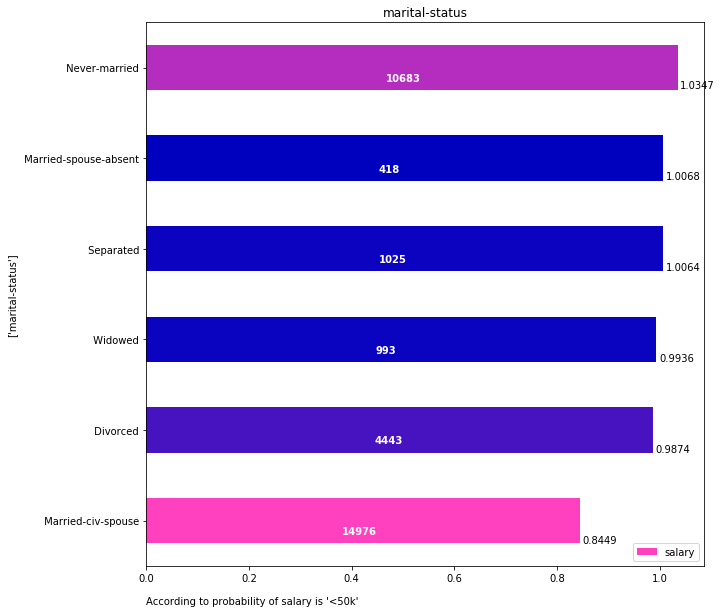

In [ ]:
part_dep.plot_part_dep(fields= ['marital-status'])

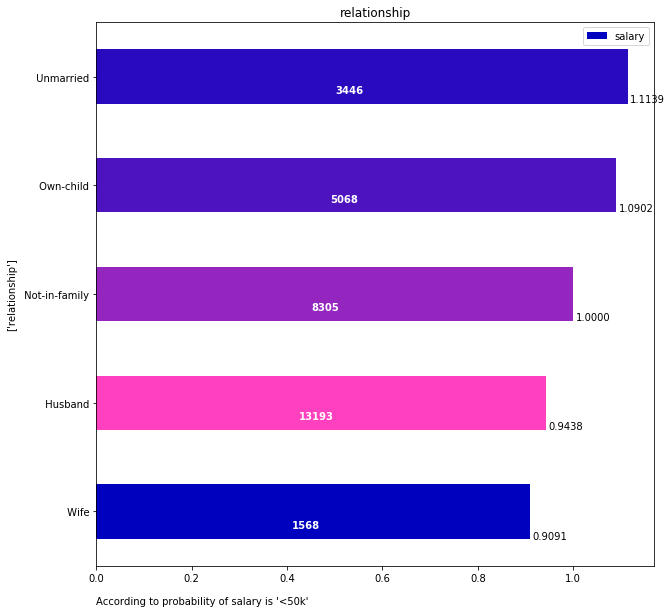

In [ ]:
part_dep.plot_part_dep(fields= ['relationship'])

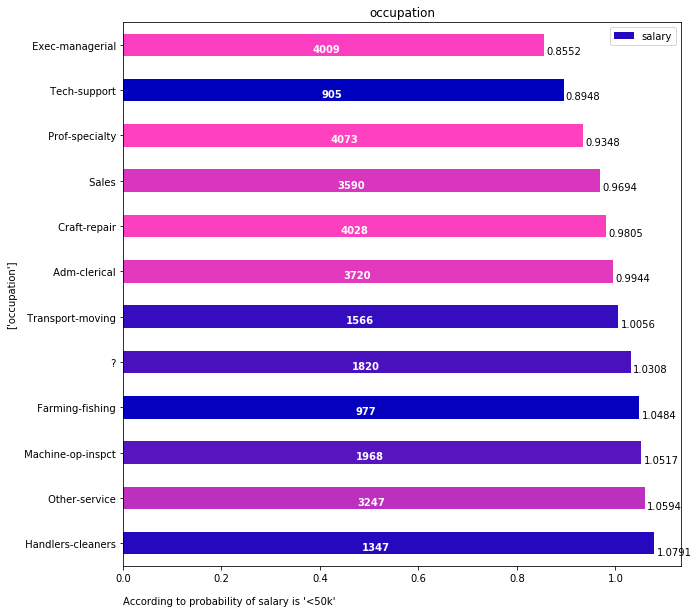

In [ ]:
part_dep.plot_part_dep(fields= ['occupation'], asc=True)

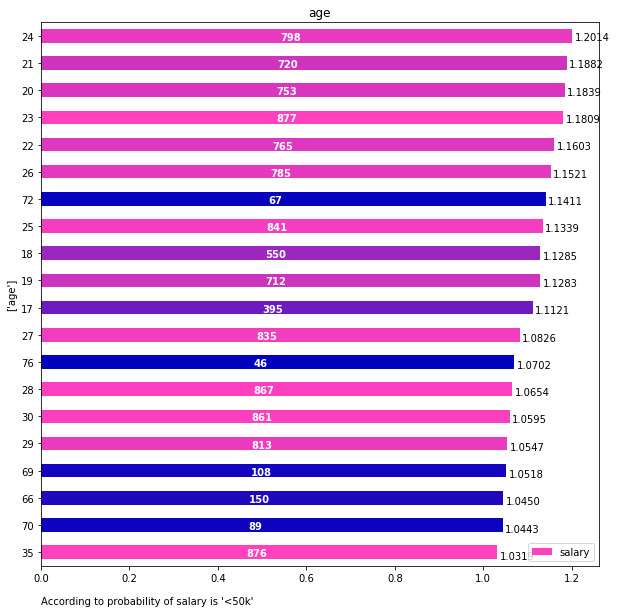

In [ ]:
part_dep.plot_part_dep(fields= ['age'])

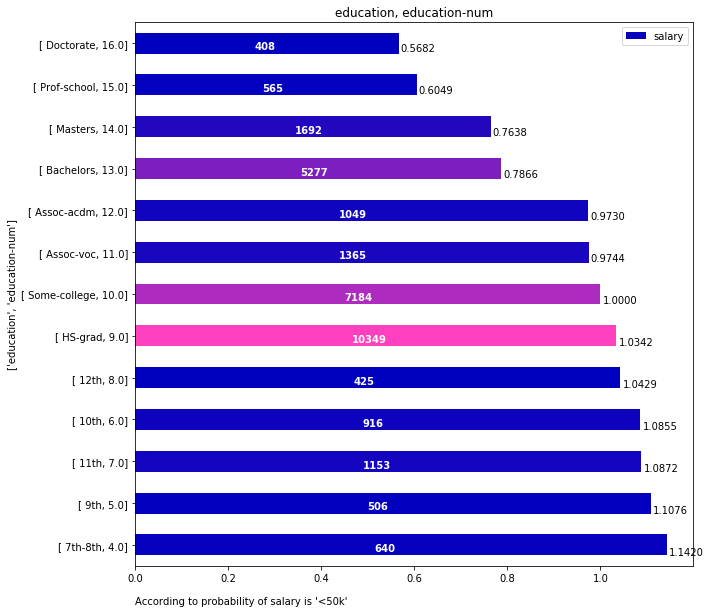

In [ ]:
part_dep.plot_part_dep(fields= ['education', 'education-num'], asc=True)

In [ ]:
part_dep.get_pd(feature='marital-status')

,marital-status,salary,times
21,Never-married,1.034719,10683.0
22,Married-spouse-absent,1.006788,418.0
23,Separated,1.006424,1025.0
24,Widowed,0.993576,993.0
25,Divorced,0.987417,4443.0
26,Married-civ-spouse,0.844909,14976.0


In [ ]:
# here we use short init version for a fast `plot_model` execution

In [ ]:
part_dep = PartDep(learn=learn, df=df, model_name='salary', 
                   fields=fields, coef=0.8, no_precalc=True)

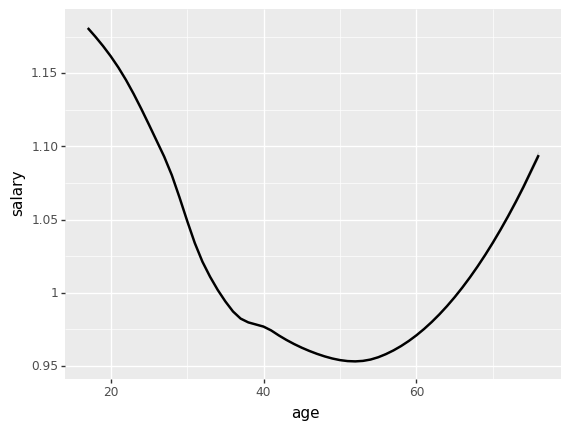

<ggplot: (8750056455717)>

In [ ]:
#takes me 3 min to run
part_dep.plot_model(field=['age'])

Methods exposed: 
- `plot_part_dep` -- plots partial dependency plot for sublist of connected `fields` 
- `get_pd` -- outputs partial dependence of a single feature in dataframe-format
- `plot_model` -- plot graph of partial dependence. Works only for number-like continious values (lake 'year made', 'age' and so on)
- `plot_raw` -- plot dependency graph from data itself. Works only for regression data
- `what_cached` -- shows what is cached
- `empty_cache` -- deletes the cache file, if you want to rerun init from the scratch